# Supervised classification Workflow Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/nickyspatial/blob/refs/heads/master/docs/examples/supervised_classification.ipynb)

This example explains how to perform supervised classification.

## Setup & Imports

We begin by importing the required modules and setting up the environment. & Download the sample quickbird satellite image for our module

In [1]:
! pip install nickyspatial


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import requests
import matplotlib.pyplot as plt

from nickyspatial import (
    LayerManager,
    MultiResolutionSegmentation,
    RuleSet,
    attach_ndvi,
    attach_shape_metrics,
    attach_spectral_indices,
    layer_to_raster,
    layer_to_vector,
    plot_classification,
    plot_layer,
    plot_layer_interactive,
    read_raster,
    MergeRuleSet,
    EnclosedByRuleSet,
    TouchedByRuleSet,
    SupervisedClassifier
)

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

raster_path = os.path.join(data_dir, "sample.tif")


if not os.path.exists(raster_path):
    url = "https://github.com/kshitijrajsharma/nickyspatial/raw/refs/heads/master/data/sample.tif"
    print(f"Downloading sample raster from {url}...")
    response = requests.get(url)
    response.raise_for_status()  # Ensure the download succeeded
    with open(raster_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded sample raster to {raster_path}")
else:
    print(f"Using existing raster at: {raster_path}")

Using existing raster at: data/Artifical_landscape_UTM_012025.tif


## Reading the Raster

We now read the raster data and print some basic information about the image.

In [3]:
image_data, transform, crs = read_raster(raster_path)
print(f"Image dimensions: {image_data.shape}")
print(f"Coordinate system: {crs}")

Image dimensions: (3, 2937, 3061)
Coordinate system: EPSG:32633


## Performing Segmentation

Here we perform multi-resolution segmentation. A `LayerManager` is used to keep track of all layers created in the process. nickyspatial packages uses a layer object which is an underlying vector segmentation tied up to the raster , similar concept as layer in ecognition

In [4]:
manager = LayerManager()

segmenter = MultiResolutionSegmentation(scale=40, compactness=0.5)
segmentation_layer = segmenter.execute(
    image_data,
    transform,
    crs,
    layer_manager=manager,
    layer_name="Base_Segmentation",
)

print("Segmentation layer created:")
print(segmentation_layer)

Number of segments: 5618
Segmentation layer created:
Layer 'Base_Segmentation' (type: segmentation, parent: None, objects: 3662)


## Visualizing Segmentation

We utilize the built-in plotting function to visualize the segmentation. The image will be displayed inline.

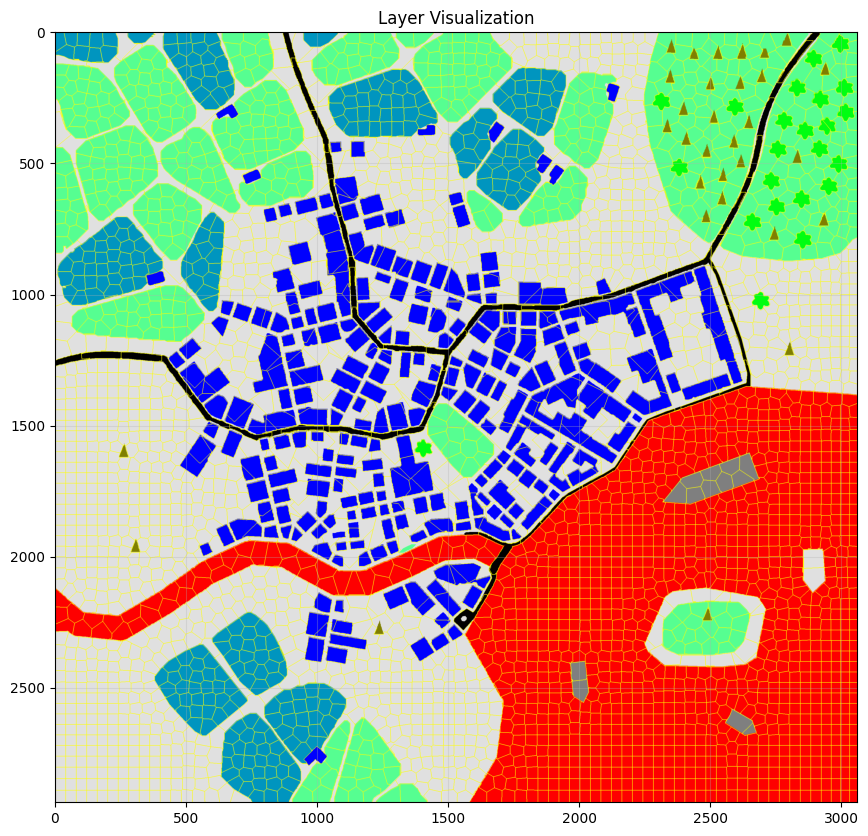

In [5]:
fig1 = plot_layer(layer=segmentation_layer, image_data=image_data, rgb_bands=(2, 1, 0), show_boundaries=True)
plt.show()

fig1.savefig(os.path.join(output_dir, "1_segmentation.png"))

In [6]:
segmentation_layer.attach_function(
    attach_ndvi,
    name="ndvi_stats",
    nir_column="band_4_mean",
    red_column="band_3_mean",
    output_column="NDVI",
)
segmentation_layer.attach_function(attach_shape_metrics, name="shape_metrics")

# fig2 = plot_layer(segmentation_layer, attribute="NDVI", title="NDVI Values", cmap="RdYlGn")
# plt.show()

## Sample data collection

Output()

Output()

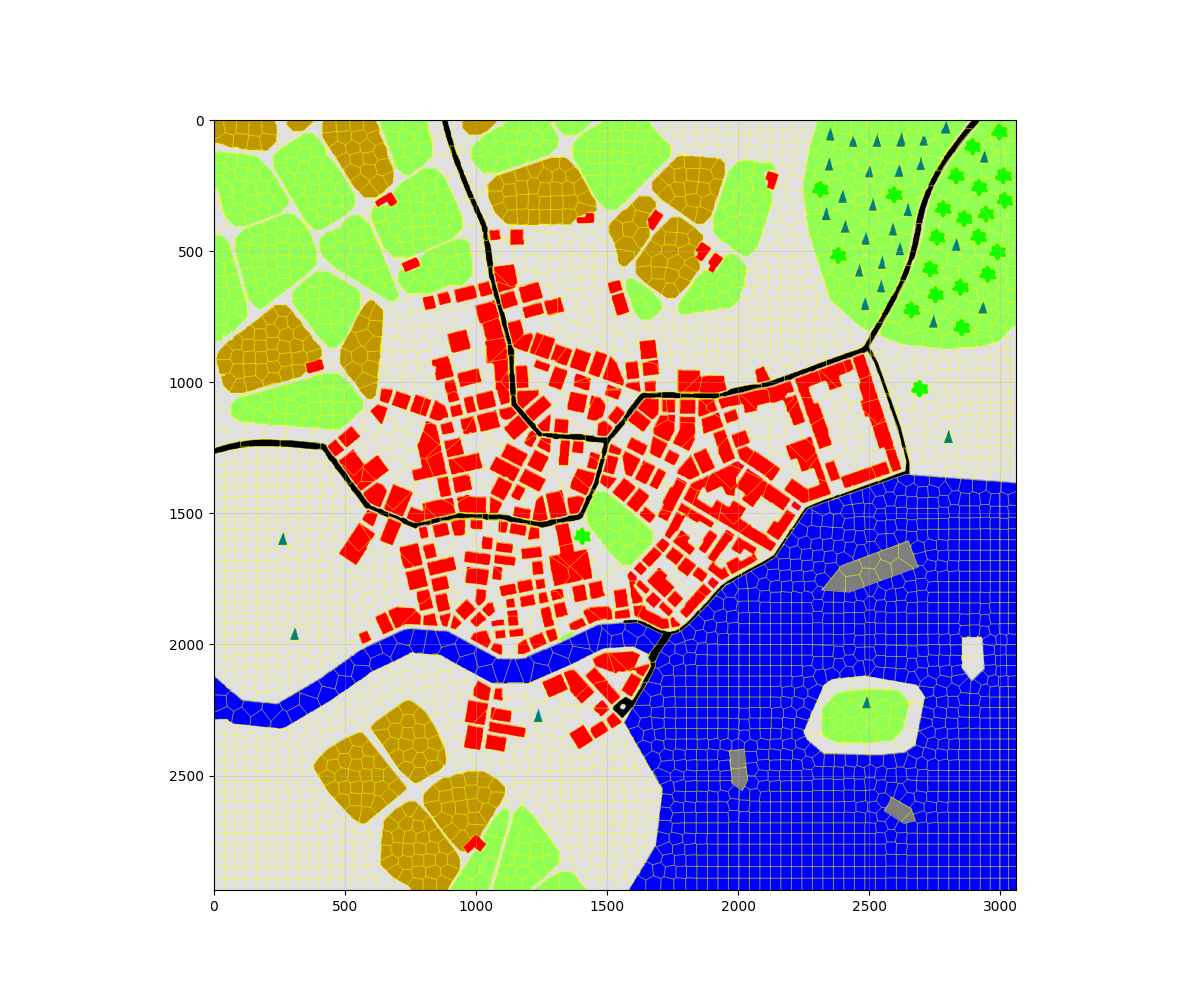

In [7]:
# plot_layer_interactive
%matplotlib widget
plot_layer_interactive(segmentation_layer,image_data=image_data)

In [8]:
# Samples for all eight different classes
samples={
"Water": [41,134,246,491],
"built-up": [12,499,290,484],
"vegetation": [36,143,239,588,371],
}

classes_color= {
    "Water": "#3437c2",
    "built-up":"#de1421",
    "vegetation": "#0f6b2f"
}

params={"n_estimators":100, "oob_score":True, "random_state":42}
RF_classification=SupervisedClassifier(name="RF Classification", classifier_type="Random Forest", classifier_params=params)
RF_classification_layer, oob_score = RF_classification.execute(segmentation_layer,samples=samples,layer_manager=manager,layer_name="RF Classification",)


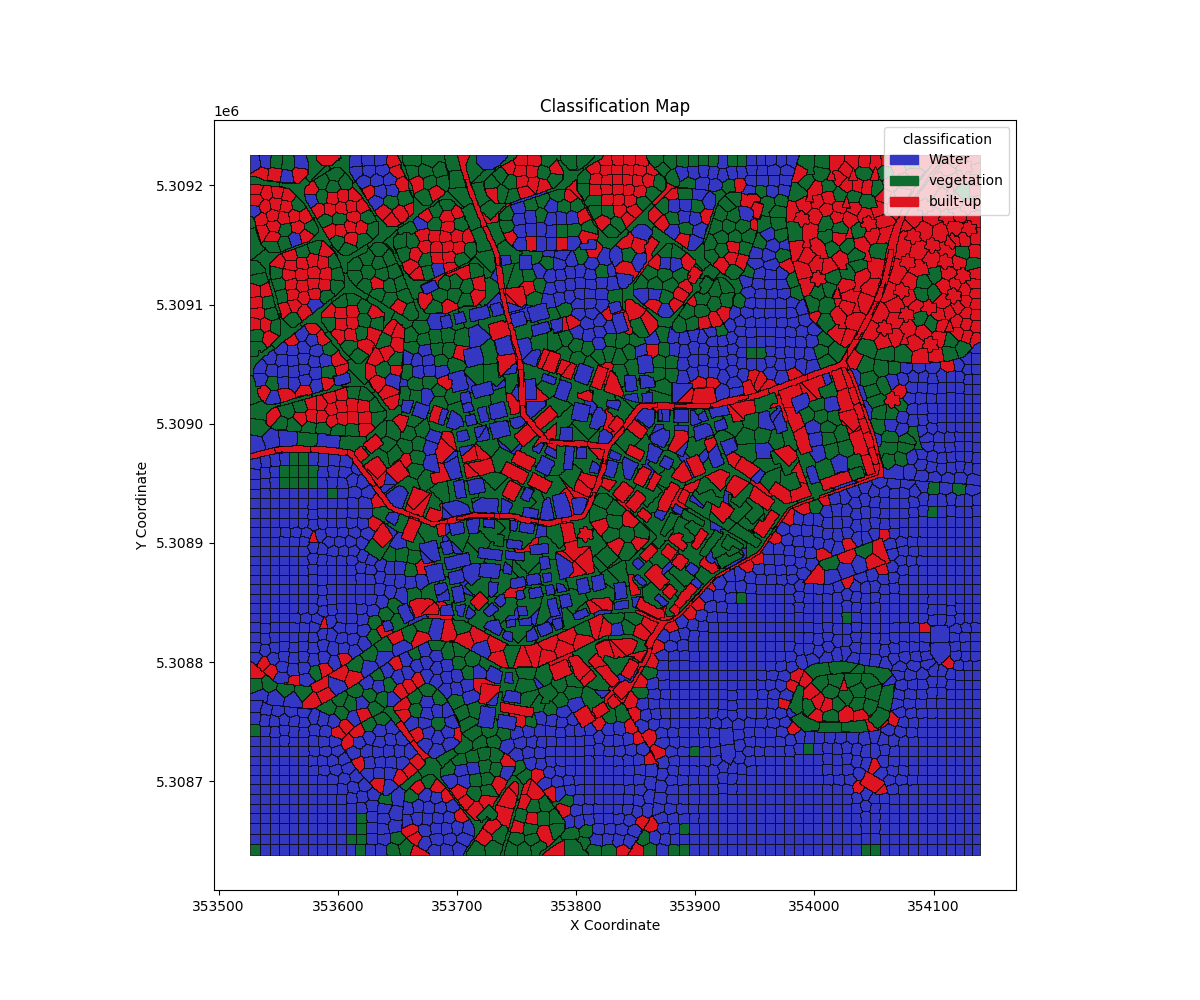

In [9]:

fig4 = plot_classification(RF_classification_layer, class_field="classification", class_color=classes_color)

plt.show()

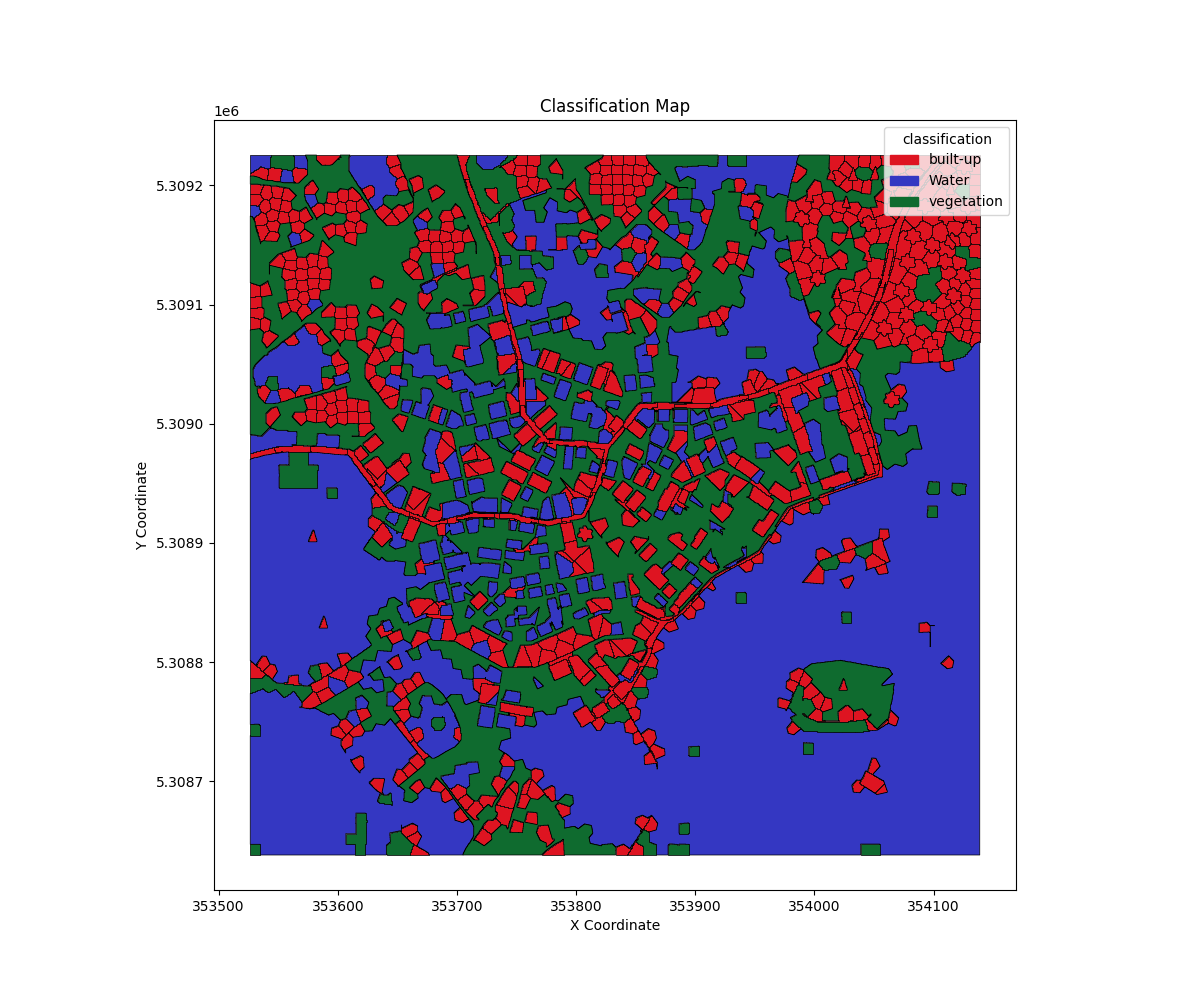

In [10]:
merger = MergeRuleSet("MergeByVegAndType")
class_value=["Water","vegetation"]
merged_layer = merger.execute(
    source_layer=RF_classification_layer,
    class_column_name="classification",
    class_value=class_value,
    layer_manager=manager,
    layer_name="Merged RF Classification",
)
fig4 = plot_classification(merged_layer, class_field="classification", class_color=classes_color)


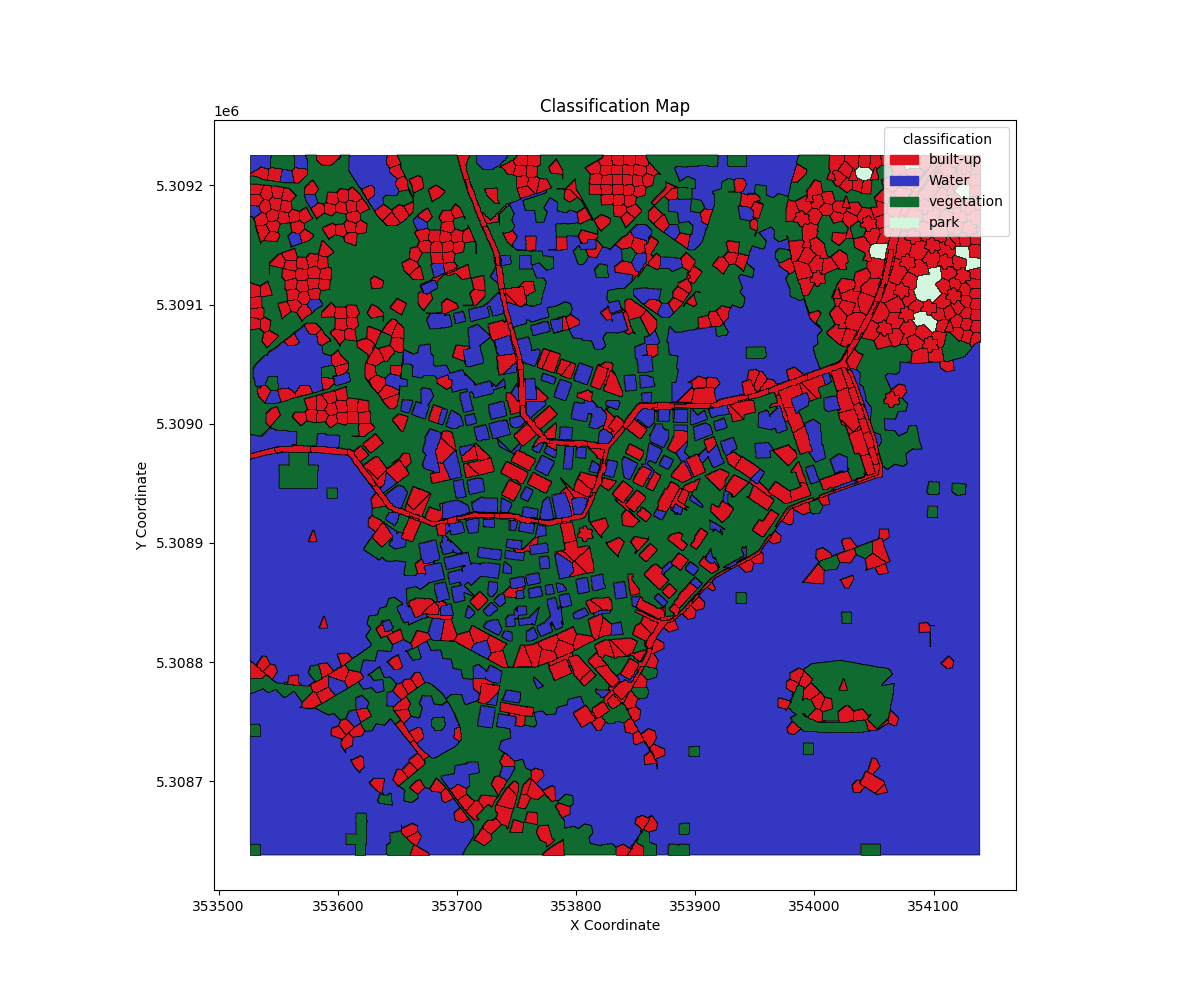

In [11]:
encloser_rule = EnclosedByRuleSet()
enclosed_by_layer = encloser_rule.execute(
    source_layer=merged_layer,
    class_column_name="classification",
    class_value_a="vegetation",
    class_value_b="built-up",
    new_class_name="park",
    layer_manager=manager,
    layer_name="enclosed_by_layer",
)
classes_color["park"]="#d2f7dc"
fig4 = plot_classification(enclosed_by_layer, class_field="classification", class_color=classes_color)

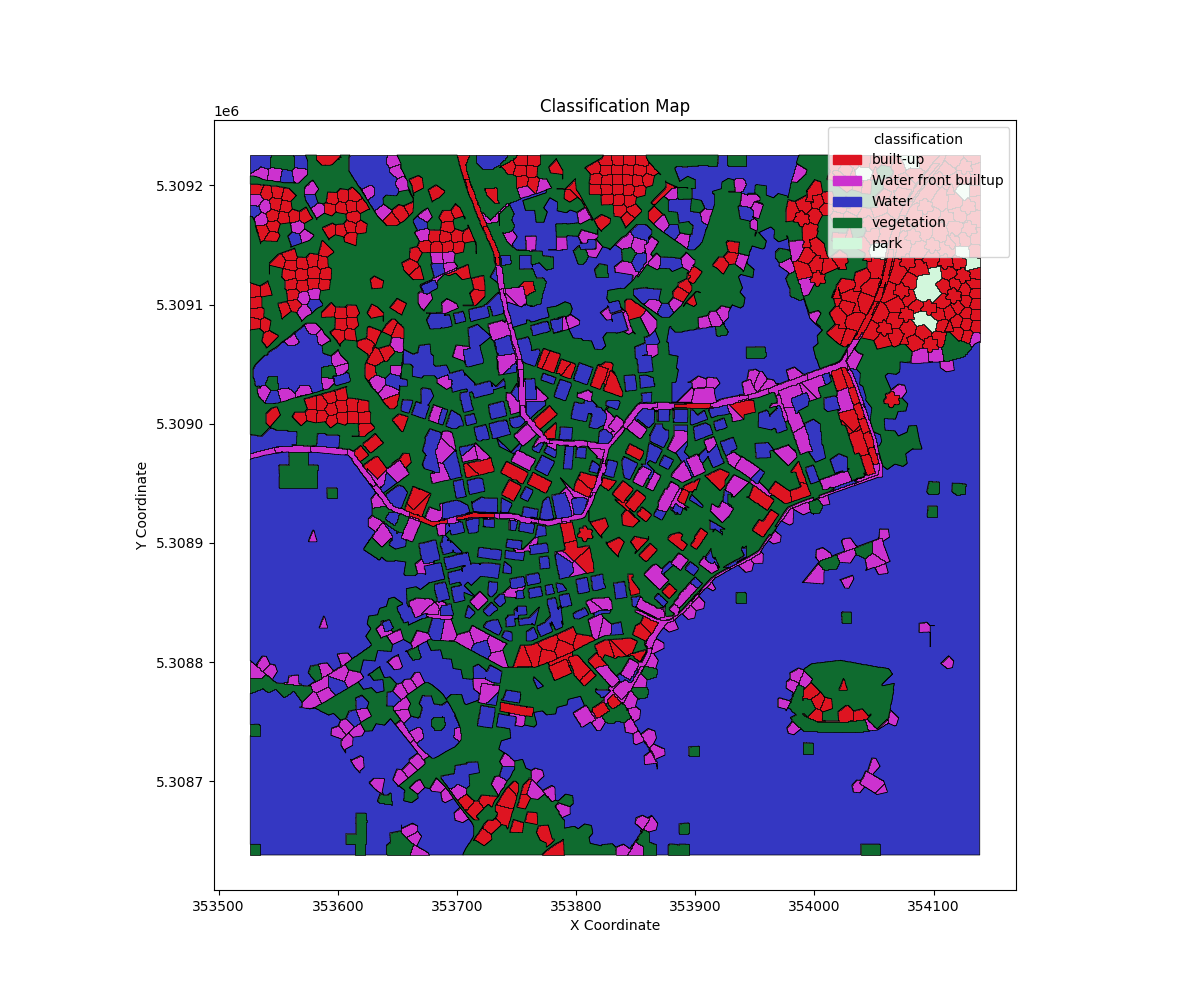

In [12]:
touched_by_rule = TouchedByRuleSet()
touched_by_layer = touched_by_rule.execute(
    source_layer=enclosed_by_layer,
    class_column_name="classification",
    class_value_a="built-up",
    class_value_b="Water",
    new_class_name="Water front builtup",
    layer_manager=manager,
    layer_name="touched_by_layer",
)
classes_color["Water front builtup"]="#cc32cf"
fig4 = plot_classification(touched_by_layer, class_field="classification", class_color=classes_color)

In [13]:
RF_classification_layer.objects.keys()

Index(['segment_id', 'area_pixels', 'area_units', 'geometry', 'band_1_mean',
       'band_1_std', 'band_1_min', 'band_1_max', 'band_1_median',
       'band_2_mean', 'band_2_std', 'band_2_min', 'band_2_max',
       'band_2_median', 'band_3_mean', 'band_3_std', 'band_3_min',
       'band_3_max', 'band_3_median', 'perimeter', 'shape_index',
       'compactness', 'classification'],
      dtype='object')

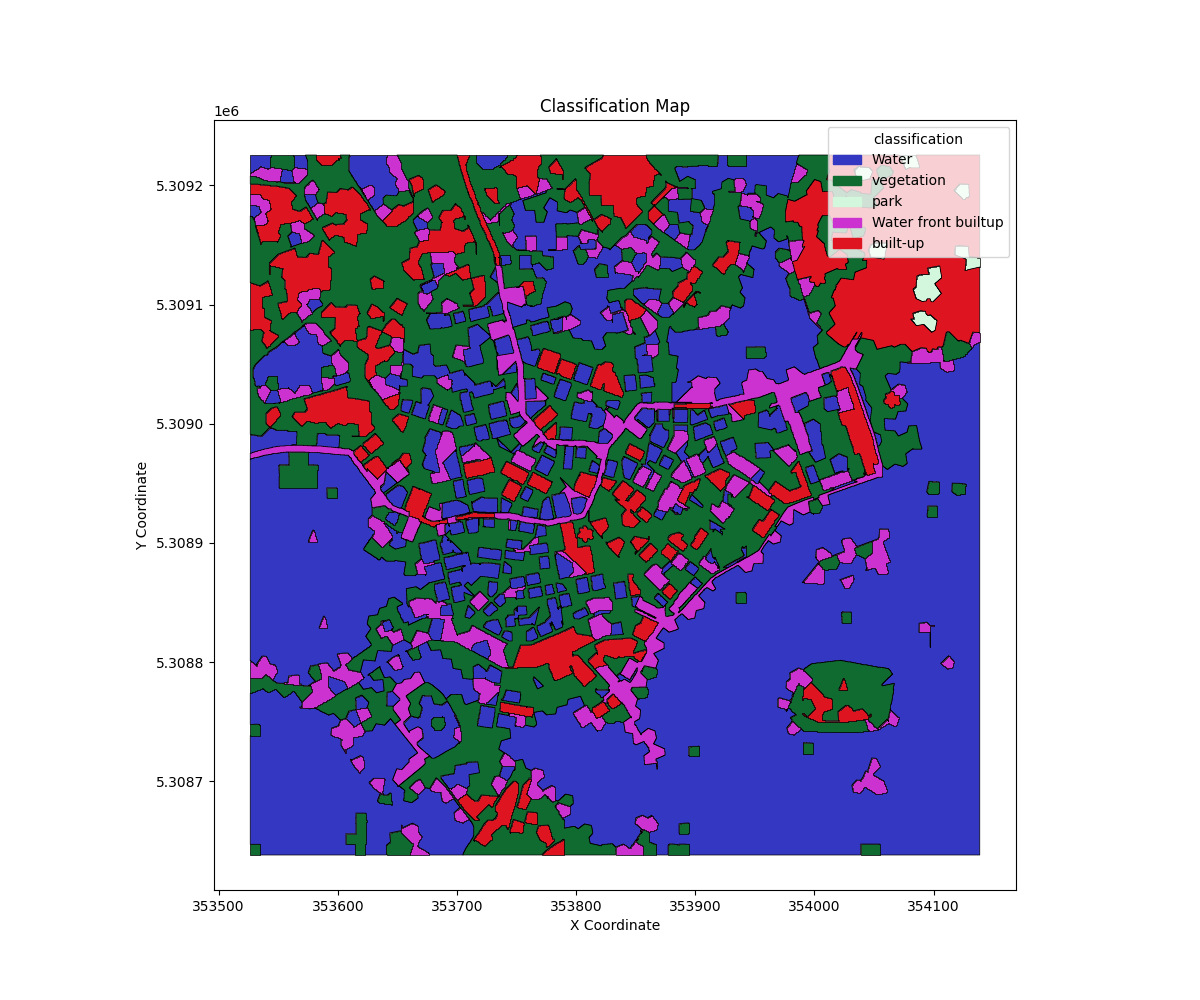

In [14]:
merge_rule = MergeRuleSet("MergeByVegAndType")
merged_layer2 = merger.execute(
    source_layer=touched_by_layer,
    class_column_name="classification",
    class_value=["Water front builtup","built-up"],
    layer_manager=manager,
    layer_name="Merged RF Classification 2",
)
fig4 = plot_classification(merged_layer2, class_field="classification", class_color=classes_color)